In [1]:
!python3 -m pip install bokeh pandas

Defaulting to user installation because normal site-packages is not writeable


In [1]:
path = '~/.ros/tracing/canopen-controller-test2'

In [2]:
# Make notebook full-width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import os
import sys
import datetime as dt
from typing import List, Optional
from typing import Tuple
from typing import Union

import numpy as np
import pandas as pd

dir = '.' # os.path.dirname(os.path.realpath(__file__))
sys.path.insert(0, os.path.join(dir, '../../tracetools_analysis/tracetools_analysis'))
sys.path.insert(0, os.path.join(dir, '../../ros2_tracing/tracetools_read'))
from tracetools_analysis.loading import load_file
from tracetools_analysis.processor.ros2 import Ros2Handler
from tracetools_analysis.utils.ros2 import Ros2DataModelUtil

In [4]:
events = load_file(path)
handler = Ros2Handler.process(events)

found converted file: /home/admin/.ros/tracing/canopen-controller-test2/converted
 [100%] [Ros2Handler]


In [5]:
data_util = Ros2DataModelUtil(handler.data)

callback_symbols = data_util.get_callback_symbols()

In [6]:
data_util.data.print_data()

====================ROS 2 DATA MODEL===================
ROS2 CANopen tracing tpdo data:


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [53]:
rc_target = data_util.data.canopen_ros2_control_target_position
tpdo_data = data_util.data.canopen_tpdo_data

In [54]:
type(tpdo_data)

pandas.core.frame.DataFrame

In [56]:
rc_target

,timestamp,name,node_id,data
0,1683639500033918809,prbt_joint_1,3,-2147483648
1,1683639500034073888,prbt_joint_1,3,-2147483648
2,1683639500034151436,prbt_joint_1,3,-2147483648
3,1683639500034223245,prbt_joint_1,3,-2147483648
4,1683639500034303540,prbt_joint_1,3,-2147483648
...,...,...,...,...
36256,1683639621560702382,prbt_joint_2,4,-3135
36257,1683639621560706941,prbt_joint_3,5,-123936
36258,1683639621560711210,prbt_joint_4,6,3074
36259,1683639621560715254,prbt_joint_5,7,-61579


In [57]:
rc_target = rc_target[rc_target['data'] != -2147483648]
rc_target

,timestamp,name,node_id,data
8205,1683639528060813490,prbt_joint_1,3,0
8206,1683639528060905130,prbt_joint_2,4,0
8207,1683639528060913584,prbt_joint_3,5,0
8208,1683639528060920421,prbt_joint_4,6,0
8209,1683639528060927364,prbt_joint_5,7,0
...,...,...,...,...
36256,1683639621560702382,prbt_joint_2,4,-3135
36257,1683639621560706941,prbt_joint_3,5,-123936
36258,1683639621560711210,prbt_joint_4,6,3074
36259,1683639621560715254,prbt_joint_5,7,-61579


In [58]:
print(rc_target.columns)

Index(['timestamp', 'name', 'node_id', 'data'], dtype='object')


In [59]:
rc_target = rc_target.drop('node_id', axis=1)
tpdo_data = tpdo_data.drop('node_id', axis=1)

In [60]:
rc_target['timestamp'] = pd.to_datetime(rc_target['timestamp'], unit='ns')
tpdo_data['timestamp'] = pd.to_datetime(tpdo_data['timestamp'], unit='ns')

# create a new column with time increments
rc_target['time_increment'] = (rc_target['timestamp'] - rc_target['timestamp'].iloc[0]).dt.total_seconds()
tpdo_data['time_increment'] = (tpdo_data['timestamp'] - tpdo_data['timestamp'].iloc[0]).dt.total_seconds()

In [61]:
# rc_target = rc_target['data'] != -2147483648 # Value added during tracing for NaN
# tpdo_data = tpdo_data['data'] != -2147483648
# rc_target = rc_target.drop(rc_target.loc[rc_target['data'] == -2147483648 ].index, inplace=True)

In [62]:
rc_target

,timestamp,name,data,time_increment
8205,2023-05-09 13:38:48.060813490,prbt_joint_1,0,0.000000
8206,2023-05-09 13:38:48.060905130,prbt_joint_2,0,0.000092
8207,2023-05-09 13:38:48.060913584,prbt_joint_3,0,0.000100
8208,2023-05-09 13:38:48.060920421,prbt_joint_4,0,0.000107
8209,2023-05-09 13:38:48.060927364,prbt_joint_5,0,0.000114
...,...,...,...,...
36256,2023-05-09 13:40:21.560702382,prbt_joint_2,-3135,93.499889
36257,2023-05-09 13:40:21.560706941,prbt_joint_3,-123936,93.499893
36258,2023-05-09 13:40:21.560711210,prbt_joint_4,3074,93.499898
36259,2023-05-09 13:40:21.560715254,prbt_joint_5,-61579,93.499902


In [63]:
divide_by_constant = lambda x: x/((180/np.pi)*1000)
rc_target['data'] = rc_target['data'].apply(divide_by_constant)
tpdo_data['data'] = tpdo_data['data'].apply(divide_by_constant)

In [72]:
tpdo_data

,timestamp,name,data,time_increment
0,2023-05-09 13:38:14.316329403,prbt_joint_1,0.004468,0.000000
1,2023-05-09 13:38:14.323297240,prbt_joint_1,0.004468,0.006968
2,2023-05-09 13:38:14.333281037,prbt_joint_1,0.004468,0.016952
3,2023-05-09 13:38:14.343475113,prbt_joint_1,0.004468,0.027146
4,2023-05-09 13:38:14.353438609,prbt_joint_1,0.004468,0.037109
...,...,...,...,...
90165,2023-05-09 13:40:21.557783077,prbt_joint_6,0.001100,127.241454
90166,2023-05-09 13:40:21.562752789,prbt_joint_5,0.001100,127.246423
90167,2023-05-09 13:40:21.563171638,prbt_joint_1,0.001100,127.246842
90168,2023-05-09 13:40:21.564431323,prbt_joint_2,0.001100,127.248102


In [65]:
# filter the name column to create separate variables
rc_prbt_joint_1 = rc_target.loc[rc_target['name'].str.contains('prbt_joint_1')]
rc_prbt_joint_2 = rc_target.loc[rc_target['name'].str.contains('prbt_joint_2')]
rc_prbt_joint_3 = rc_target.loc[rc_target['name'].str.contains('prbt_joint_3')]
rc_prbt_joint_4 = rc_target.loc[rc_target['name'].str.contains('prbt_joint_4')]
rc_prbt_joint_5 = rc_target.loc[rc_target['name'].str.contains('prbt_joint_5')]
rc_prbt_joint_6 = rc_target.loc[rc_target['name'].str.contains('prbt_joint_6')]

In [66]:
tpdo_prbt_joint_1 = tpdo_data.loc[tpdo_data['name'].str.contains('prbt_joint_1')]
tpdo_prbt_joint_2 = tpdo_data.loc[tpdo_data['name'].str.contains('prbt_joint_2')]
tpdo_prbt_joint_3 = tpdo_data.loc[tpdo_data['name'].str.contains('prbt_joint_3')]
tpdo_prbt_joint_4 = tpdo_data.loc[tpdo_data['name'].str.contains('prbt_joint_4')]
tpdo_prbt_joint_5 = tpdo_data.loc[tpdo_data['name'].str.contains('prbt_joint_5')]
tpdo_prbt_joint_6 = tpdo_data.loc[tpdo_data['name'].str.contains('prbt_joint_6')]

In [67]:
tpdo_prbt_joint_1

,timestamp,name,data,time_increment
0,2023-05-09 13:38:14.316329403,prbt_joint_1,0.004468,0.000000
1,2023-05-09 13:38:14.323297240,prbt_joint_1,0.004468,0.006968
2,2023-05-09 13:38:14.333281037,prbt_joint_1,0.004468,0.016952
3,2023-05-09 13:38:14.343475113,prbt_joint_1,0.004468,0.027146
4,2023-05-09 13:38:14.353438609,prbt_joint_1,0.004468,0.037109
...,...,...,...,...
90143,2023-05-09 13:40:21.523371380,prbt_joint_1,0.001100,127.207042
90149,2023-05-09 13:40:21.533464719,prbt_joint_1,0.001100,127.217135
90155,2023-05-09 13:40:21.543125740,prbt_joint_1,0.001100,127.226796
90161,2023-05-09 13:40:21.553144798,prbt_joint_1,0.001100,127.236815


In [68]:
rc_prbt_joint_1

,timestamp,name,data,time_increment
8205,2023-05-09 13:38:48.060813490,prbt_joint_1,0.000000,0.000000
8211,2023-05-09 13:38:48.080765970,prbt_joint_1,0.000000,0.019952
8217,2023-05-09 13:38:48.100722757,prbt_joint_1,0.000000,0.039909
8223,2023-05-09 13:38:48.120720011,prbt_joint_1,0.000000,0.059907
8229,2023-05-09 13:38:48.140843495,prbt_joint_1,0.000000,0.080030
...,...,...,...,...
36231,2023-05-09 13:40:21.480851532,prbt_joint_1,-0.306654,93.420038
36237,2023-05-09 13:40:21.500698616,prbt_joint_1,-0.306654,93.439885
36243,2023-05-09 13:40:21.520677534,prbt_joint_1,-0.306654,93.459864
36249,2023-05-09 13:40:21.541321868,prbt_joint_1,-0.306654,93.480508


In [55]:
!python3 -m pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [76]:
import matplotlib.pyplot as plt

# create a figure and axis object
fig, ax = plt.subplots()

# plot the data column in tpdo_prbt_joint_1
tpdo_joint_1_data = np.array(tpdo_prbt_joint_1['data'])
tpdo_joint_1_ti = np.array(tpdo_prbt_joint_1['time_increment'])
ax.plot(tpdo_joint_1_ti, tpdo_joint_1_data, label='tpdo_prbt_joint_1')

# plot the data column in rc_prbt_joint_1
rc_joint_1_data = np.array(rc_prbt_joint_1['data'])
rc_joint_1_ti = np.array(rc_prbt_joint_1['time_increment'])
ax.plot(rc_joint_1_ti, rc_joint_1_data, label='rc_prbt_joint_1')

# set the axis labels and title
ax.set_xlabel('Time Increment')
ax.set_ylabel('Data')
ax.set_title('Comparison of tpdo_prbt_joint_1 and rc_prbt_joint_1')


# add a legend to the plot
ax.legend()
plt.gcf().set_dpi(200)
# show the plot
plt.show()

In [62]:
time_diff = np.diff(tpdo_prbt_joint_1['timestamp']).astype(np.float64)

# calculate the expected time increment
time_increment = np.mean(tpdo_prbt_joint_1['time_increment'])

# check if any time differences are greater than the expected time increment
if any(time_diff > time_increment):
    print('Data skip detected!')
else:
    print('No data skip detected.')

num_skips = np.sum(time_diff > time_increment)

print(f'Total number of time skips: {num_skips}')

Data skip detected!
Total number of time skips: 9934


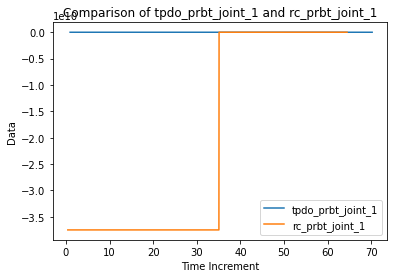

In [59]:
fig, ax = plt.subplots()

# plot the data column in tpdo_prbt_joint_1
tpdo_joint_2_data = np.array(tpdo_prbt_joint_2['data'])
tpdo_joint_2_ti = np.array(tpdo_prbt_joint_2['time_increment'])
ax.plot(tpdo_joint_2_ti, tpdo_joint_2_data, label='tpdo_prbt_joint_1')

# plot the data column in rc_prbt_joint_1
rc_joint_2_data = np.array(rc_prbt_joint_2['data'])
rc_joint_2_ti = np.array(rc_prbt_joint_2['time_increment'])
ax.plot(rc_joint_2_ti, rc_joint_2_data, label='rc_prbt_joint_1')

# set the axis labels and title
ax.set_xlabel('Time Increment')
ax.set_ylabel('Data')
ax.set_title('Comparison of tpdo_prbt_joint_1 and rc_prbt_joint_1')

# add a legend to the plot
ax.legend()

# show the plot
plt.show()